# Introduction

See PyTorch's [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.learner import *
from fastai.column_data import *

//anaconda/envs/fastai-cpu2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/envs/fastai-cpu2/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from datetime import datetime
from torchvision import transforms
import torch.nn as nn
from utils import *
plt.rcParams['figure.figsize'] = [12, 4]
pd.set_option('display.max_rows', 11)

In [4]:
# import os
# import re
# import dill as pickle
# import itertools
# from datetime import datetime
# from tqdm import tqdm_notebook
# import numpy as np
# import pandas as pd
# from pandas import Series, DataFrame
# pd.set_option('display.max_rows', 40)
# import matplotlib as mpl
# from matplotlib import pyplot as plt
# import matplotlib.transforms as mtransforms
# plt.rcParams['figure.figsize'] = [12, 4]

# from sklearn.metrics import confusion_matrix

# from utils import *

# import torch
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# import torch.nn as nn
# import torch.optim as optim

# Simulated prices

**// TO DO:**

* Define a class that inherits `ModelData` from fastai's **dataset.py** with `trn_dl`, `trn_ds`, `val_dl`, `val_ds`, `test_dl`, `test_ds`. See fastai's **column_data.py** and **model.py**.
* Define a learner that inherits from class `Learner` (see **learner.py**).
* Add a `get_learner` method as in fastai's [column_data.py](https://github.com/fastai/fastai/blob/master/fastai/column_data.py) `CollabFilterDataset`.


* Simulated data ($L$ days) split between train data (days $0$ to $L_T$) and validation data (days $L_T - warmup$ to $L$).
* Test data: new simulation.
* Simulation of prices with different volatilities, drifts, return distributions and autocorrelation.


## Data Generation

In [5]:
def sim_path(N=500, sigma=0.35, S0=1, dt=1/250,
             mu=[0.05, 0.05], P=np.array([[0.95, 0.05], [0.1, 0.9]]),
             wdt_hl=2):
    
    # State simulation
    state = np.random.randint(0, 2)
    states = [state]
    for t in range(N - 1):
        state = int(np.random.multinomial(1, P[state, :]).argmax())
        states.append(state)
    
    # Price simulation
    drift = (np.array([mu[s] for s in states[1:]]) - 0.5 * sigma**2) * dt
    wiener = np.random.randn(N - 1) * sigma * np.sqrt(dt)

    S = S0 * np.concatenate((np.ones(1), np.exp(np.cumsum(drift + wiener))))
    
    res_df = DataFrame(data=dict(Close=S))
    res_df = res_df.assign(Date = pd.date_range(start=datetime(2018, 1, 1),
                                                periods=N, freq='D')).set_index('Date')
    
    res_df = res_df.assign(Open = res_df.Close.shift(-1).fillna(method='ffill') * \
                                    np.exp((np.random.rand(N) - 0.5) * sigma * np.sqrt(dt)))
    
    res_df = res_df.assign(High = res_df[['Open', 'Close']].max(axis=1) * \
                                np.exp(np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)),
                           Low = res_df[['Open', 'Close']].min(axis=1) * \
                                np.exp(- np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)))

    return res_df[['Open', 'High', 'Low', 'Close']]

In [6]:
price_df = add_changes(clean_trends(find_trends(sim_path())))
price_df

,Open,High,Low,Close,Smoothed,Trend,n_Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End,Ch,Ch2,Ch3,Ch4
Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.024561,1.069049,0.960043,1.000000,1.076109,1.0,1.0,0.249231,0.068791,0.155075,0.018812,1.539729,1.257701,5.046321,2018-01-01,2018-05-06,0.000000,0.000000,0.000000e+00,0.000000e+00
2018-01-02,1.024381,1.070546,1.009288,1.021137,1.076289,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-06,0.020917,0.000438,9.151109e-06,1.914102e-07
2018-01-03,1.044894,1.057524,1.027569,1.028179,1.076587,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-06,0.006873,0.000047,3.246429e-07,2.231214e-09
2018-01-04,1.034471,1.053392,1.002190,1.047624,1.077003,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-06,0.018735,0.000351,6.575888e-06,1.231986e-07
2018-01-05,1.036301,1.077029,1.019179,1.035107,1.077534,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-05-06,-0.012020,0.000144,-1.736588e-06,2.087352e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-11,2.320963,2.352028,2.186797,2.264309,2.235146,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-28,2019-05-15,-0.030382,0.000923,-2.804449e-05,8.520467e-07
2019-05-12,2.407920,2.454546,2.224760,2.299060,2.236398,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-28,2019-05-15,0.015231,0.000232,3.533165e-06,5.381275e-08
2019-05-13,2.404358,2.518878,2.306011,2.415800,2.237294,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-28,2019-05-15,0.049530,0.002453,1.215079e-04,6.018284e-06


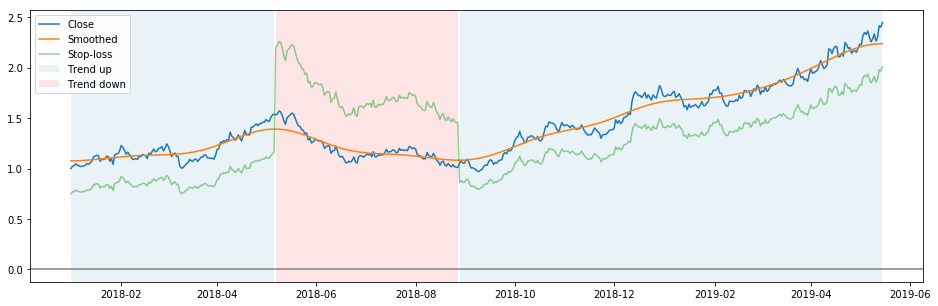

In [7]:
plot_trends(price_df)

## Dataset Class

In [8]:
def get_trend(df, sd, min_icagr=None,
              targets=['Trend', 'Max_Drawdown', 'ICAGR', 'Bliss'],
              is_multi=True):

    t_df = find_trends(df, sd)
    if min_icagr:
        t_df = clean_trends(t_df)

    t_df = t_df.loc[:, targets]
    if 'Trend' in targets and is_multi:
        t_df.Trend = t_df.Trend.add(1).astype(np.long)  # 0 = Down, 1 = No Trend, 2 = Up.
    t_df = t_df.rename({t: t + '_' + str(sd) for t in targets}, axis=1)
    
    return t_df

In [9]:
class SimulatedPricesDataset(Dataset):
    """Simulated Prices Dataset"""
    def __init__(self, N, sim_fun, 
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR', 'Bliss'],
                 sds=[5, 10, 20, 30], min_icagr=None,
                 Ch=None,
                 tech_windows=None,
                 is_multi=True,
                 transform=None):
        """
        Args:
            N (int): number of prices to simulate.
            sim_fun: function that returns a simulated price DataFrame: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.N = N
        self.sim_fun = sim_fun
        self.targets = targets
        self.features = features
        self.sds = sds
        self.min_icagr = min_icagr
        self.Ch = Ch
        self.tech_windows = tech_windows
        self.transform = transform
        self.samples = []
        self.is_multi = is_multi
        self.is_reg = not is_multi
        
        for i in tqdm_notebook(range(N)):
            sim_df = self.sim_fun()
        
            targets_df = pd.concat(
                (get_trend(sim_df, s, min_icagr=self.min_icagr, targets=self.targets, is_multi=self.is_multi)
                 for s in self.sds),
                axis=1,
            )

            if self.tech_windows:
                sim_df = add_technical(add_changes(sim_df), windows=self.tech_windows)
            elif self.Ch:
                sim_df = add_changes(sim_df)

            if self.features:
                sim_df = sim_df[self.features]

            sample = {'features': sim_df, 'targets': targets_df}
            self.samples.append(sample)
        
        self.n_features = self.samples[0]['features'].shape[1]
        self.n_targets = self.samples[0]['targets'].shape[1]
        self.features_columns = self.samples[0]['features'].columns
        self.targets_columns = self.samples[0]['targets'].columns
    
    
    def __len__(self):
        return self.N
    
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [10]:
sim_dataset = SimulatedPricesDataset(10, lambda: sim_path(N=800),
                                     targets=['Trend'], sds = [20],
                                     min_icagr=0.3, tech_windows=[30, 100])

In [11]:
sim_dataset.n_features, sim_dataset.n_targets

(20, 1)

In [12]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)

(800, 20) (800, 1)


In [13]:
sim_j['features'].columns

Index(['Open', 'High', 'Low', 'Close', 'Ch', 'Ch2', 'Ch3', 'Ch4', 'SMA_30',
       'SMA_100', 'sigma2_SMA_30', 'sigma2_SMA_100', 'skew_SMA_30',
       'skew_SMA_100', 'kurt_SMA_30', 'kurt_SMA_100', 'Support_30',
       'Support_100', 'Resistance_30', 'Resistance_100'],
      dtype='object')

In [14]:
sim_j['features'].head().T

Date,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00
Open,0.974093,0.997461,1.017321,1.046387,1.040847
High,1.023143,1.007492,1.028765,1.091027,1.044154
Low,0.932929,0.961917,0.970239,0.988463,1.021408
Close,1.000000,0.969760,0.995564,1.021275,1.035566
Ch,0.000000,-0.030707,0.026261,0.025497,0.013897
...,...,...,...,...,...
kurt_SMA_100,-1.000000,-1.000000,-1.463901,-1.627913,-1.511604
Support_30,0.932929,0.932929,0.932929,0.932929,0.932929
Support_100,0.932929,0.932929,0.932929,0.932929,0.932929
Resistance_30,1.023143,1.023143,1.028765,1.091027,1.091027


In [15]:
sim_j['targets'].head().T

Date,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00
Trend_20,2,2,2,2,2


## Transforms

In [16]:
class ToArray(object):
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        return {'features': features.values, 'targets': targets.values}
        

class RandomCrop(object):
    """Crops randomly an inner segment of the time series.
    
    Args:
        output_size (int): length of the desired time series.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        
        size = len(features)
        if self.output_size < size:
            start = np.random.randint(0, size - self.output_size)
            features = features[start: start + self.output_size, :]
            targets = targets[start: start + self.output_size, :]
        
        return {'features': features, 'targets': targets}


class StartAt(object):
    def __init__(self, at):
        assert at > 0
        self.at = at
    
    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']
        # Open starts at self.at
        features[:, :4] = self.at * features[:, :4] / features[0, 0]
        
        return {'features': features, 'targets': targets}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        features, targets = sample['features'], sample['targets']

        return {'features': torch.from_numpy(features), 
                'targets': torch.from_numpy(targets)}

In [17]:
# sim_dataset = SimulatedPricesDataset(...,
#                                      transform=transforms.Compose([
#                                          ToArray(), RandomCrop(480)
#                                      ])
#                                     )

sim_dataset.transform = transforms.Compose([ToArray(), RandomCrop(480)])

(480, 20) (480, 1)


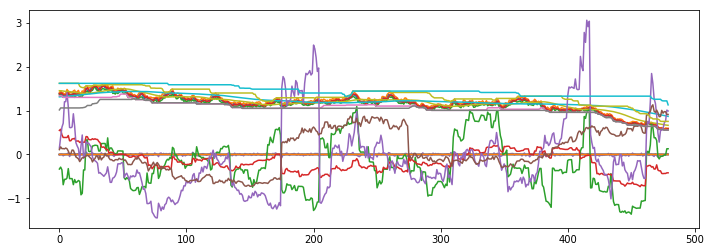

In [18]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)
plt.plot(sim_j['features']);

In [19]:
composed = transforms.Compose([ToArray(), RandomCrop(480), StartAt(100), ToTensor()])

sim_dataset.transform = composed

In [20]:
sim_j = sim_dataset[2]
print(sim_j['features'].size(), sim_j['targets'].size())

torch.Size([480, 20]) torch.Size([480, 1])


In [21]:
sim_j['features'][:6, :4]

tensor([[100.0000, 100.3591,  97.1706, 100.1897],
        [101.1315, 104.1037,  98.6811,  99.0415],
        [ 98.5233, 103.7602,  95.1423, 100.2487],
        [ 99.6092, 100.3345,  96.8374,  98.0805],
        [101.7273, 104.7091,  99.0652, 100.5607],
        [105.7566, 107.5509,  98.0536, 101.8903]], dtype=torch.float64)

In [22]:
sim_j['targets'][:6, :]

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1]])

## Iterating through the dataset

In [23]:
sds = [20]
tech_win = [10]
min_icagr = 0.3

train_dataset = SimulatedPricesDataset(100, lambda: sim_path(N=500),
                                       targets=['Trend'],
                                       sds=sds, min_icagr=min_icagr,
                                       tech_windows=tech_win,
                                       transform=transforms.Compose([
                                           ToArray(),
                                           RandomCrop(480),
                                           ToTensor()
                                       ]))

test_dataset = SimulatedPricesDataset(50, lambda: sim_path(N=300),
                                      targets=['Trend'],
                                      sds=sds, min_icagr=min_icagr,
                                      tech_windows=tech_win,
                                      transform=transforms.Compose([
                                          ToArray(),
                                          ToTensor()
                                      ]))

//anaconda/envs/fastai-cpu2/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print('Train:')
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

print('Test:')
for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

Train:
0 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
1 torch.Size([50, 480, 14]) torch.Size([50, 480, 1])
Test:
0 torch.Size([50, 300, 14]) torch.Size([50, 300, 1])


In [25]:
input = next(iter(train_loader))['features']
input

tensor([[[ 0.9923,  1.0135,  0.9803,  ..., -1.0000,  0.9634,  1.0135],
         [ 1.0068,  1.0415,  0.9638,  ..., -0.0049,  0.9634,  1.0415],
         [ 1.0035,  1.0233,  0.9662,  ..., -0.3871,  0.9634,  1.0415],
         ...,
         [ 0.7955,  0.8127,  0.7571,  ...,  0.7577,  0.7445,  0.8998],
         [ 0.8218,  0.8278,  0.7787,  ...,  0.6378,  0.7445,  0.8998],
         [ 0.8259,  0.8334,  0.7859,  ...,  0.9617,  0.7445,  0.8998]],

        [[ 1.0250,  1.0629,  0.9901,  ..., -1.4572,  0.9089,  1.0661],
         [ 1.0539,  1.0714,  0.9846,  ..., -1.5552,  0.9089,  1.0714],
         [ 1.0614,  1.1051,  1.0485,  ..., -1.5066,  0.9089,  1.1051],
         ...,
         [ 0.5664,  0.5836,  0.5604,  ..., -1.1241,  0.5236,  0.6083],
         [ 0.5723,  0.5926,  0.5599,  ..., -0.8936,  0.5236,  0.6083],
         [ 0.5823,  0.5935,  0.5650,  ..., -0.8406,  0.5236,  0.6017]],

        [[ 1.0551,  1.1327,  1.0528,  ...,  2.2290,  0.9858,  1.1517],
         [ 1.0379,  1.0892,  1.0176,  ...,  0

In [26]:
next(iter(input.chunk(input.size(1), dim=1))).shape

torch.Size([50, 1, 14])

In [27]:
next(iter(input.chunk(input.size(1), dim=1))).view(-1, 14).size()

torch.Size([50, 14])

## ModelData

In [28]:
class PriceModelData(ModelData):
    
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True, call=None):
        
        self.call = call
        
        if test_ds is not None:
                test_dl = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)
        super().__init__(path, 
                         torch.utils.data.DataLoader(trn_ds, bs, shuffle=shuffle),
                         torch.utils.data.DataLoader(val_ds, bs, shuffle=False),
                         test_dl)
    
    @classmethod
    def simulate(cls, N, bs, sim_fun=sim_path, n_days=500,
                 targets=['Trend'],
                 sds=[10, 20, 30], min_icagr=0.5,
                 Ch=True,
                 tech_windows=[10, 20, 30],
                 features=None,
                 ):
        
        
        call = dict(N=N, n_days=n_days, sim_fun=sim_fun,
                    targets=targets, features=features,
                    sds=sds, min_icagr=min_icagr,
                    Ch=Ch, tech_windows=tech_windows)
        
        trn_N, val_N, test_N = N
        trn_ds = SimulatedPricesDataset(trn_N, lambda: sim_path(N=n_days + 30),
                                        targets=['Trend'],
                                        sds=sds, min_icagr=min_icagr,
                                        tech_windows=tech_windows,
                                        transform=transforms.Compose([
                                            ToArray(),
                                            RandomCrop(n_days - 30),
                                            ToTensor()
                                        ]))
        val_ds = SimulatedPricesDataset(val_N, lambda: sim_path(N=n_days),
                                        targets=['Trend'],
                                        sds=sds, min_icagr=min_icagr,
                                        tech_windows=tech_windows,
                                        transform=transforms.Compose([
                                            ToArray(),
                                            ToTensor()
                                        ]))
        test_ds = SimulatedPricesDataset(test_N, lambda: sim_path(N=n_days),
                                         targets=['Trend'],
                                         sds=sds, min_icagr=min_icagr,
                                         tech_windows=tech_windows,
                                         transform=transforms.Compose([
                                             ToArray(),
                                             ToTensor()
                                         ]))
        
        return cls('input/Sim/', trn_ds, val_ds, bs, test_ds, True, call)
        
        

In [29]:
sim_data = PriceModelData.simulate((20, 10, 10), bs=10, sds=[20])

In [30]:
input = next(iter(sim_data.trn_dl))['features']
input

tensor([[[1.0884, 1.1136, 1.0867,  ..., 1.1691, 1.1691, 1.1691],
         [1.1266, 1.1369, 1.0842,  ..., 1.1691, 1.1691, 1.1691],
         [1.1167, 1.1260, 1.1112,  ..., 1.1691, 1.1691, 1.1691],
         ...,
         [1.4665, 1.5057, 1.4253,  ..., 1.5447, 1.5933, 1.5933],
         [1.4498, 1.4912, 1.4366,  ..., 1.5447, 1.5933, 1.5933],
         [1.4310, 1.5194, 1.3902,  ..., 1.5447, 1.5933, 1.5933]],

        [[0.9989, 1.0321, 0.9513,  ..., 1.0658, 1.0658, 1.0658],
         [1.0002, 1.0326, 0.9522,  ..., 1.0658, 1.0658, 1.0658],
         [1.0142, 1.0234, 0.9738,  ..., 1.0658, 1.0658, 1.0658],
         ...,
         [1.3020, 1.3821, 1.2550,  ..., 1.3821, 1.3821, 1.3821],
         [1.3102, 1.3626, 1.2930,  ..., 1.3821, 1.3821, 1.3821],
         [1.2997, 1.3470, 1.2474,  ..., 1.3821, 1.3821, 1.3821]],

        [[0.9430, 0.9559, 0.9037,  ..., 1.0021, 1.0021, 1.0021],
         [0.9197, 0.9700, 0.9084,  ..., 1.0021, 1.0021, 1.0021],
         [0.9407, 0.9584, 0.9262,  ..., 1.0021, 1.0021, 1.

## LSTM Model

**// TO DO:**

* See fastai's [column_data.py](https://github.com/fastai/fastai/blob/master/fastai/column_data.py) `MixedInputModel` for list comprehension of layers. `self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])`.
* Multiple dimension softmax and `NLLLoss`, for Trend_5, Trend_10, etc.
* Weights in loss function: prob(no trend) really low.

In [32]:
input_t = next(iter(input.chunk(input.size(1), dim=1)))
input_t.size()

torch.Size([10, 1, 26])

In [104]:
input_t.view(-1, 26).dtype

torch.float64

In [102]:
aux = nn.LSTMCell(26, 20)
# aux.float()

In [107]:
aux(input_t.view(-1, 26).float(), (torch.zeros(10, 20).float(), torch.zeros(10, 20).float()))

(tensor([[ 0.1087, -0.0984,  0.0030, -0.0433, -0.0934, -0.1955,  0.0118,  0.1292,
           0.1623,  0.0485,  0.0482, -0.0300, -0.0885,  0.1605, -0.1551,  0.1201,
          -0.0087,  0.1625,  0.2836, -0.2339],
         [-0.0311, -0.0767, -0.0613, -0.0248, -0.0473, -0.2632, -0.0297,  0.1809,
           0.1715,  0.0202,  0.0703,  0.0299, -0.0084,  0.2727, -0.1565,  0.1470,
           0.0219,  0.0296,  0.2741, -0.2711],
         [-0.0639, -0.1024, -0.0587, -0.0349, -0.0506, -0.2222,  0.0521,  0.1475,
           0.1457,  0.0231,  0.0351, -0.0092, -0.1017,  0.2771, -0.2286,  0.1599,
           0.0123,  0.0252,  0.2413, -0.2392],
         [-0.0281, -0.1138, -0.0937, -0.0181, -0.0312, -0.0594, -0.0109,  0.1881,
           0.2235, -0.0286,  0.1154, -0.1054, -0.0125,  0.2577, -0.2049,  0.1499,
           0.0104, -0.0803,  0.2482, -0.1791],
         [ 0.0574, -0.1246, -0.0160, -0.0534, -0.0694, -0.1114,  0.0742,  0.1080,
           0.1432,  0.0415,  0.0465, -0.1032, -0.1650,  0.1805, -0.2428,  

In [114]:
class Sequence(nn.Module):
    def __init__(self, h0=1, h1=51, h2=51, hL=3, warmup=60, nll_weights=None):
        super(Sequence, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1).float()
        self.lstm2 = nn.LSTMCell(h1, h2).float()
        self.linear = nn.Linear(h2, hL).float()
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.warmup = 60
        self.loss_fun = nn.NLLLoss(weight=nll_weights)
        
    
    def init_hidden(self):
        self.h_t = torch.zeros(input.size(0), self.h1).float()
        self.c_t = torch.zeros(input.size(0), self.h1).float()
        self.h_t2 = torch.zeros(input.size(0), self.h2).float()
        self.c_t2 = torch.zeros(input.size(0), self.h2).float()

    
    def forward(self, input):
        self.init_hidden()
        outputs = []
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            self.h_t, self.c_t = self.lstm1(input_t.view(-1, self.h0).float(), (self.h_t, self.c_t))
            self.h_t2, self.c_t2 = self.lstm2(self.h_t, (self.h_t2, self.c_t2))
            output = self.linear(self.h_t2)
            output = self.softmax(output)
            outputs += [output]

        outputs = torch.stack(outputs, 1)
        return outputs
    

    def loss(self, y_hat, y_true):
        loss = 0
        for i in range(self.warmup, y_hat.size()[1]):
            loss = loss + self.loss_fun(y_hat[:, i, :], y_true[:, i, :].squeeze(dim=1))
        return loss / (y_hat.size()[1] - self.warmup)

In [115]:
Series(np.concatenate([sim_j['targets'].numpy().flatten() for sim_j in sim_dataset])).value_counts()

0    2203
2    2094
1     503
dtype: int64

In [116]:
_, freqs = np.unique([sim_j['targets'].numpy().flatten() for sim_j in train_dataset], return_counts=True)
weights = torch.Tensor(freqs / sum(freqs))

In [117]:
# build the model
#seq = Sequence(h0=train_loader.dataset.n_features, nll_weights=weights)
seq = Sequence(h0=sim_data.trn_dl.dataset.n_features, nll_weights=weights)
seq

Sequence(
  (lstm1): LSTMCell(26, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=3, bias=True)
  (softmax): LogSoftmax()
  (loss_fun): NLLLoss()
)

In [118]:
sample = next(iter(sim_data.trn_dl))  # next(iter(train_loader))
inputs = sample['features']
targets = sample['targets']

In [119]:
out = seq(inputs)

In [120]:
out.size(), targets.size()

(torch.Size([10, 470, 3]), torch.Size([10, 470, 1]))

In [121]:
seq.loss(out, targets)

tensor(1.1227, grad_fn=<DivBackward0>)

In [122]:
test_sample = next(iter(sim_data.test_dl))  # next(iter(test_loader))
test_inputs = test_sample['features']
test_targets = test_sample['targets']

In [123]:
with torch.no_grad():
    test_out = seq(test_inputs)
test_out.size()

torch.Size([10, 500, 3])

In [124]:
seq.loss(test_out, test_targets)

tensor(1.1366)

In [133]:
fit(seq, sim_data, 2, optim.SGD(seq.parameters(), 1e-3, momentum=0.9), seq.loss)

  0%|          | 0/2 [00:00<?, ?it/s]


NotImplementedError: <U8

### Learner

In [134]:
model_summary(seq, 1)

TypeError: 'int' object is not iterable

In [126]:
class PriceModelLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return seq.loss

    def summary(self): return model_summary(self.model, [torch.ones(3).long(), torch.ones(3).long()])


In [127]:
sim_learner = PriceModelLearner(sim_data, BasicModel(seq, name='seq'))
sim_learner

Sequence(
  (lstm1): LSTMCell(26, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=3, bias=True)
  (softmax): LogSoftmax()
  (loss_fun): NLLLoss()
)

In [130]:
sim_learner.fit(1e-3, 2)

  0%|          | 0/2 [00:00<?, ?it/s]


NotImplementedError: <U8

### Train

#### Find lr

In [94]:
losses = []
lrs = np.exp(np.arange(np.log(1e-6), np.log(1), step=0.1))
sched_lrs = []
optimizer = optim.Adam(seq.parameters(), lr=1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lrs[epoch])


for e in tqdm_notebook(np.arange(len(lrs) // (len(train_dataset) / train_loader.batch_size) + 1),
                       desc='Epoch:'):

    for i_batch, sample_batched in tqdm_notebook(enumerate(train_loader), desc='Mini-batch:', leave=False):
        inputs, targets = sample_batched['features'], sample_batched['targets']
        scheduler.step()
        sched_lrs.append(scheduler.get_lr())
        def closure():
            optimizer.zero_grad()
            out = seq(inputs)
            loss = seq.loss(out, targets)
            losses.append(loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        
        if scheduler.last_epoch == len(lrs) - 1: break
    if scheduler.last_epoch == len(lrs) - 1: break


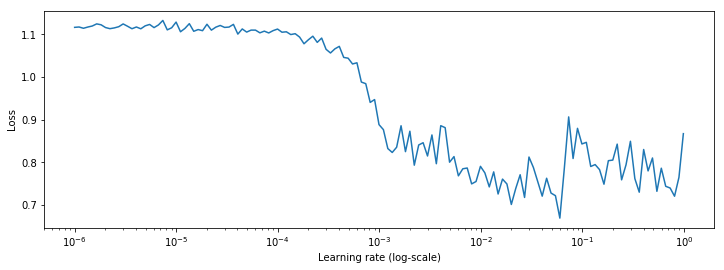

In [95]:
plt.semilogx(np.array(sched_lrs).flatten()[:250], losses[:250])
plt.xlabel('Learning rate (log-scale)')
plt.ylabel('Loss')
plt.show()

#### Train the model

In [97]:
losses = []
test_losses = []
seq = Sequence(h0=train_dataset.n_features, nll_weights=weights)
seq.double()

Sequence(
  (lstm1): LSTMCell(14, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=3, bias=True)
  (softmax): LogSoftmax()
  (loss_fun): NLLLoss()
)

In [115]:
optimizer = optim.Adam(seq.parameters(), lr=1e-4)
# optimizer = optim.SGD(seq.parameters(), lr=1e-3, momentum=0.9)

In [116]:
epochs = 10
for e in tqdm_notebook(range(epochs), desc='Epoch:'):
    
    for i_batch, sample_batched in tqdm_notebook(enumerate(train_loader), desc='Mini-batch:', leave=False):
        inputs, targets = sample_batched['features'], sample_batched['targets']
    
        def closure():
            optimizer.zero_grad()
            out = seq(inputs)
            loss = seq.loss(out, targets)
            losses.append(loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    
    if e % 1 == 0:
        with torch.no_grad():
            test_sample = next(iter(test_loader))
            test_inputs, test_targets = test_sample['features'], test_sample['targets']
            test_out = seq(test_inputs)
            test_loss = seq.loss(test_out, test_targets)
            test_losses.append(test_loss.item())
        print('Epoch: ', e,
              ', training loss: ', np.mean(losses[-(len(train_dataset) // train_loader.batch_size):]),
              ', test loss: ', test_loss.item(), sep='')


Epoch: 0, training loss: 0.6959984932100256, test loss: 0.758437879921061


Epoch: 1, training loss: 0.6934497047750812, test loss: 0.7582789784238455


Epoch: 2, training loss: 0.6937716332477409, test loss: 0.756387478398797


Epoch: 3, training loss: 0.6928217132565851, test loss: 0.7558873149497315


Epoch: 4, training loss: 0.6933980075242903, test loss: 0.7556627411376763


Epoch: 5, training loss: 0.6918859664140873, test loss: 0.7549143899937315


Epoch: 6, training loss: 0.6918120202663062, test loss: 0.7542905581698034


Epoch: 7, training loss: 0.6911097395588419, test loss: 0.7544207195773296


Epoch: 8, training loss: 0.6903377705400484, test loss: 0.7533493032687466


Epoch: 9, training loss: 0.6902901073449019, test loss: 0.7525716209955368


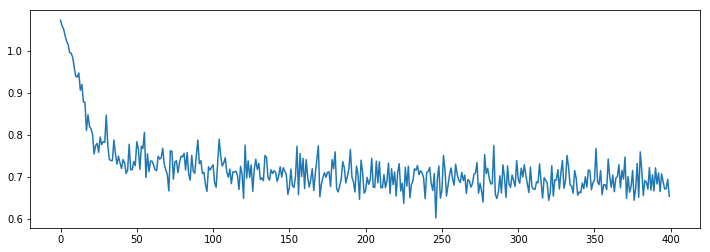

In [125]:
plt.plot(losses)

In [118]:
test_sample = next(iter(test_loader))
test_inputs, test_targets = test_sample['features'], test_sample['targets']
test_out = seq(test_inputs)

In [119]:
j = np.random.randint(len(test_dataset))
features_j = test_inputs[j, ...]
x_j = pd.DataFrame(features_j.numpy(), columns=test_dataset.features_columns)

In [120]:
targets_j = test_targets[j, ...]
y_j = pd.DataFrame(targets_j.numpy(), columns=test_dataset.targets_columns)

In [121]:
out_j = test_out[j, ...]
yh_j = pd.DataFrame(np.exp(out_j.detach().numpy()), columns=['Down', 'No_Trend', 'Up'])
yh_j = yh_j.assign(y_hat = pd.DataFrame(np.exp(out_j.detach().numpy())).idxmax(axis=1))

In [122]:
confusion_matrix(y_j.values, yh_j.y_hat)/len(y_j)

array([[0.11333333, 0.        , 0.21666667],
       [0.06666667, 0.        , 0.11      ],
       [0.12666667, 0.        , 0.36666667]])

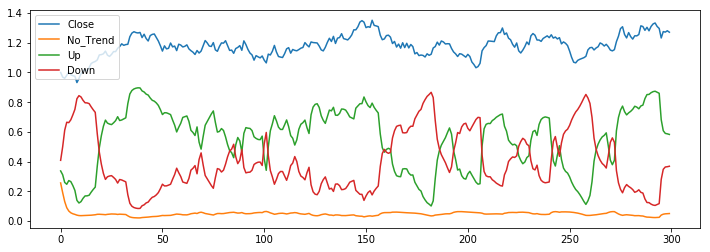

In [123]:
res_j = pd.concat((x_j, y_j, yh_j), axis=1)
res_j[['Close', 'No_Trend', 'Up', 'Down']].plot()

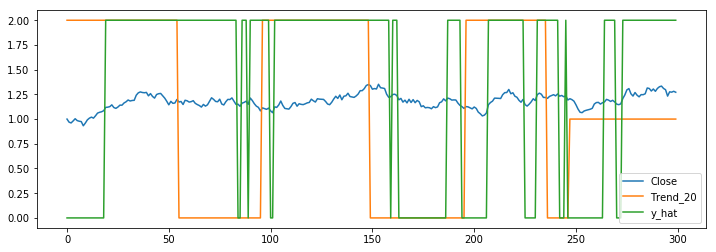

In [124]:
res_j[['Close', 'Trend_20', 'y_hat']].plot()

# Sharadar prices //

> // How to manage train and validation samples?

In [ ]:
class SharadarPricesDataset(Dataset):
    """Sharadar Prices Dataset"""
    def __init__(self, root_dir, min_length,
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR', 'Bliss'],
                 sds=[5, 10, 20, 30], min_icagr=None, 
                 transform=None):
        """
        Args:
            root_dir (str): directory with data frames: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.min_length = min_length
        self.targets = targets
        self.features = features
        self.sds = sds
        self.min_icagr = min_icagr
        self.transform = transform
        
        # Only series longer than min_length
        tickers = os.listdir(root_dir)
        lengths = [len(pd.read_feather(os.path.join(root_dir, f)))
                   for f in tickers]
        tickers_df = DataFrame(data={'ticker': tickers, 'length': lengths})
        self.fnames = list(
            tickers_df.query('length > ' + str(self.min_length)).ticker.values
        )
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        
        f_name = os.path.join(self.root_dir,
                              self.fnames[idx])
        
        df = pd.read_feather(f_name).set_index('Date')
        
        targets_df = pd.concat(
            (get_trend(df, s, min_icagr=self.min_icagr, targets=self.targets)
             for s in self.sds),
            axis=1,
        )
        
        if self.features:
            df = df[self.features]
        
        sample = {'features': df, 'targets': targets_df}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [ ]:
sh_train = 'input/Quandl/Sharadar/train/'

sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3)
print(len(sh_dataset), 'series.')

In [ ]:
sh_j = sh_dataset[2]
print(sh_j['features'].shape, sh_j['targets'].shape)

In [ ]:
sh_j['features'].head().T

In [ ]:
sh_j['targets'].head().T

## Transforms

In [ ]:
# sh_train = 'input/Quandl/Sharadar/train/'
# sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3,
#                                    transform=transforms.Compose([
#                                        ToArray(),
#                                        RandomCrop(500),
#                                        StartAt(1),
#                                        ToTensor(),
#                                      ])
#                                    )

In [ ]:
composed = transforms.Compose([
    ToArray(),
    RandomCrop(300),
    StartAt(1),
    ToTensor()
])

sh_dataset.transform = composed
print(len(sh_dataset), 'series.')

In [ ]:
sh_j = sh_dataset[2]
print(sh_j['features'].size(), sh_j['targets'].size())

In [ ]:
plt.plot(sh_j['features'][:, :4].numpy());

In [ ]:
plt.plot(sh_j['features'][:, 4].numpy());

In [ ]:
plt.plot(sh_j['features'][:, 5:].numpy());

## DataLoader

In [ ]:
sh_loader = DataLoader(sh_dataset, batch_size=6)

for i_batch, sample_batched in enumerate(sh_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

# End

In [ ]:
df = pd.read_feather('input/Quandl/Sharadar/train/NIOBF.feather').set_index('Date')
df = find_trends(df)

In [ ]:
df

In [ ]:
(df.Trend_End - df.Trend_Start).min()

In [ ]:
plot_trends(df)

In [ ]:
df.Ratio.dropna().sort_values()

# TO DO:

* Check why the ratio is < 0.
* `SharadarPricesDataset` that computes data and saves it to disk on `__init__`, and only loads df on `__get_item__`.